# Example: Geometric Brownian Motion (GBM) Simulation of Historical Price Data

## Background
[Geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) is a continuous-time stochastic process model in which the random variable $S(t)$, e.g., the share price of `XYZ` is described by a deterministic drift corrupted by a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process):

$$\frac{dS}{S} = {\mu}dt + \sigma{dW}$$

The constant $\mu$ denotes a drift parameter, $\sigma$ indicates a volatility parameter, and $dW$ represents the output of a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process).  Using [Ito's lemma](https://en.wikipedia.org/wiki/Itô%27s_lemma), we can formulate an analytical solution to the GBM equation:

$$S(t) = S_{\circ}\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})Z(0,1)\Biggr]$$

where $S_{\circ}$ denotes the sharte price at $t_{\circ}$, and $Z(0,1)$ denotes a [standard normal random variable](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution). 

## Learning Objectives
In this example, we will focus on:
* __Objective 1__: Using historical data, we will begin by estimating the values for the drift parameters $\mu$ and $\sigma$ in the Geometric Brownian motion (GBM) analytical solution.
* __Objective 2__: Next, we will compare the model's predictions of share prices for various time ranges with actual market values.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3`


## Prerequisite: Load and Clean the Historical Price Dataset

Next, we load the Open High Low Close (OHLC) data files for all firms for `Year-1 ... Year-5` using the `loaddatafile(...)` function. This function returns a `DataFrame` holding a year’s worth of data (approximately 252 records). Since we are loading multiple years of data for each firm, we combine all the annual `DataFrame` instances into a single `DataFrame` using the [DataFrame append! function](https://docs.juliahub.com/DataFrames/AR9oZ/0.21.5/lib/functions/#Base.append!). We store the combined `DataFrames` in the `dataset` dictionary where keys corresponding to the `firm_id`:

In [2]:
dataset = Dict{Int64,DataFrame}();
set_of_firms = generate_firm_index_set();

years = ["Year-1", "Year-2", "Year-3", "Year-4", "Year-5"];
while (isempty(set_of_firms) == false)
    firm_index = pop!(set_of_firms)
    
    for year ∈ years
        tmp_data = loaddatafile(firm=firm_index, year=year);
        
        if (haskey(dataset,firm_index) == false)
            dataset[firm_index] = tmp_data;
        else
            append!(dataset[firm_index], tmp_data)
        end
    end
end

Not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or were delisted, etc. We will exclude these firms from the `dataset`.

#### Implementation
First, we specify the `max_number_of_records` variable, which holds the number of trading records we expect for each firm, in this case, `1256`. Then, we iterate through the firms in the `dataset` using a `for` loop. We remove those firms from the `dataset` whose row count (calculated by calling the `nrow(...)` function) is not equal to the `max_number_of_records`; a firm is removed from the `dataset` using the [delete! function](https://docs.julialang.org/en/v1/base/collections/#Base.delete!):

In [3]:
max_number_of_records = 1256
number_of_firms = length(dataset)
for (firm_index, data) ∈ dataset
    data = dataset[firm_index];
    
    if (nrow(data) != max_number_of_records)
        delete!(dataset, firm_index);
    end
end

Finally, let's select a random firm to explore in this study by calling the `rand` function of the keys of the `dataset` dictionary

In [4]:
firm_index = keys(dataset) |> collect |> rand;
println("The (randomly) selected firm in this study: $(firm_index)")

The (randomly) selected firm in this study: 101


## Objective 1: Estimate the $\mu$ and $\sigma$ parameters from the training data set

### Estimate the $\mu$ parameter
Suppose there was no noise in the system; the volatility parameter $\sigma=0$. In this case, the GBM solution becomes deterministic:

$$S(t) = S_{\circ}\exp\bigl[{\mu}\left(t-t_{\circ}\right)\bigr]$$

Rearranging the `ln` of the deterministic solution gives the linear expression:

$$\ln{S(t)} = \ln{S_{\circ}} + \mu\left(t-t_{\circ}\right)$$

We can estimate the parameter $\mu$ by finding the slope of the `ln` of the historical price data. However, this data (as we shall see) is noisy. Thus, let's construct a [least-squares estimate](https://en.wikipedia.org/wiki/Least_squares) of the drift $\hat{\mu}$ by solving the [normal equations](./background/CS3220-L10-Bindel.pdf). 

Let $\mathbf{A}$ denote the $\mathcal{S}\times{2}$ matrix holding the time values, where each row corresponds to a time value; the first column of $A$ is all 1's while the second column holds the $(t-t_{\circ})$ values. Further, let $\mathbf{Y}$ denote the price values of `firm_id` (in the same order as the $A$ matrix). Then, the y-intercept and slope can be estimated by solving the `overdetermined` system of equations:

$$\mathbf{A}\mathbf{\theta} = \mathbf{Y}$$

where $\mathbf{\theta}$ denotes the vector of unknown parameters. This system can be solved as:

$$\theta = (A^{T}A)^{-1}A^{T}Y$$

where $\mathbf{A}^{T}$ denotes the transpose of the matrix $\mathbf{A}$.

In [5]:
firm_data = dataset[firm_index];
number_of_trading_days = nrow(firm_data);

all_range = range(1,stop=number_of_trading_days,step=1) |> collect
T_all = all_range*(1.0/252.0) .- (1.0/252.0)

# Setup the normal equations -
A = [ones(number_of_trading_days) T_all];
Y = log.(firm_data[!,:volume_weighted_average_price]);

# Solve the normal equations -
θ = inv(transpose(A)*A)*transpose(A)*Y;

# get estimated μ -
b̂ = exp(θ[1]);
μ̂ = θ[2];

#### Visualize

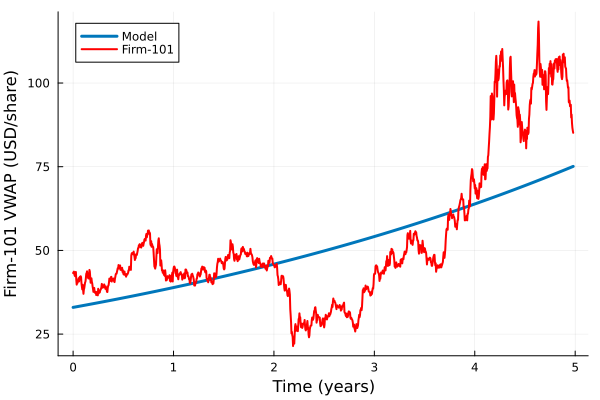

In [6]:
S = b̂*exp.(μ̂*T_all)
plot(T_all, S, lw=3, c=colors[2],label="Model")
plot!(T_all,firm_data[:,:volume_weighted_average_price], lw=2, c=:red, label="Firm-$(firm_index)")
xlabel!("Time (years)", fontsize=18)
ylabel!("Firm-$(firm_index) VWAP (USD/share)", fontsize=18)

### Estimate the $\sigma$ parameter
There are multiple methods to calculate the volatility parameter $\sigma$. Generally, these approaches can be classified into two categories - historical volatility estimates based on return data and future volatility estimates based on the [Implied Volatility (IV)](https://en.wikipedia.org/wiki/Implied_volatility) of [put and call options contracts](https://en.wikipedia.org/wiki/Option_(finance)). For now, let's focus on computing the volatility $\sigma$ from historical data and talk about options later.

#### Historical volatility
The historic volatility is estimated by analyzing the distribution of returns. To do this, let's assume a share price model of the form:

$$
S_{j} = \exp\left(\mu_{j,j-1}\Delta{t}\right)\cdot{S_{j-1}}
$$

where $\mu_{j,j-1}$ denotes the _growth rate_ (units: 1/time) and $\Delta{t}$ (units: time) denotes the time step during the time period $(j-1)\rightarrow{j}$. Solving for the return parameter $\mu_{j,j-1}$ gives the expression:

$$
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{j}}{S_{j-1}}\right)
$$

We use daily data; thus, the natural time frame between $S_{j-1}$ and $S_{j}$ is a single day. However, subsequently, it will be easier to use an annualized value for the $\mu$ parameter; thus, we let $\Delta{t} = 1/365$, or $\Delta{t} = 1/252$, i.e., the fraction of a calendar or trading year that occurs in a single day.

##### Implementation
After specifying a value for $\Delta{t}$, we define an array that holds the values for $\mu_{j,j-1}$, named `growth_rate_array`. We then populate the `growth_rate_array` using a `for` loop; during each pass through the loop, we get values for $S_{j-1}$ and $S_{j}$, i.e., the VWAP for the two days from the dataset `firm_data`, and then compute (and store) the annualized value of $\mu_{j,j-1}$ parameter in the `growth_rate_array`:

In [7]:
Δt = (1.0/252.0);
growth_rate_array = Array{Float64,1}(undef, number_of_trading_days-1)
for j ∈ 2:number_of_trading_days
    
    S₁ = firm_data[j-1, :volume_weighted_average_price];
    S₂ = firm_data[j, :volume_weighted_average_price];
    growth_rate_array[j-1] = (1/Δt)*log(S₂/S₁);
end

The `growth_rate_array` holds the values for the _annualized_ daily growth rate parameters $\mu_{j,j-1}$. Let's visualize the _return array_ which is simply the product $\mu\cdot\Delta{t}$ by plotting the [histogram](https://docs.juliaplots.org/latest/series_types/histogram/#histogram). Further, let's overlay [Normal](https://en.wikipedia.org/wiki/Normal_distribution) and [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) distributions estimated from the `growth_rate_array` onto to the same axis for comparison:

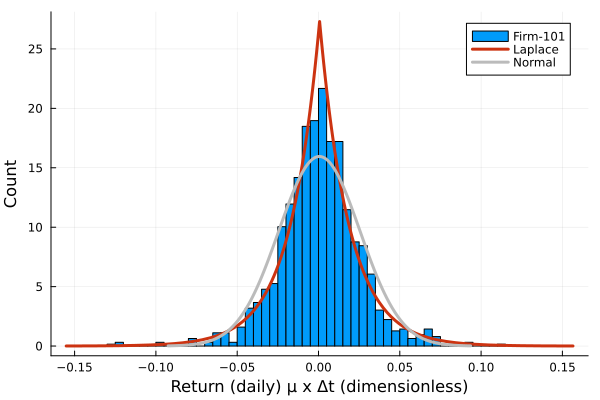

In [8]:
R = growth_rate_array.*Δt;
histogram(R, xlabel="Return (daily) μ x Δt (dimensionless)", normalize=:true, 
    ylabel="Count", label="Firm-$(firm_index)")
ld = fit_mle(Laplace, R);
nd = fit_mle(Normal, R);
plot!(ld, lw=3, c=colors[5],label="Laplace")
plot!(nd, lw=3, c=colors[7], label="Normal")

We approximate the historical volatility parameter $\sigma$ from the variance of the returns computed from the historical data set. In particular, we   we the return data to a `Normal` distribution using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), and then computed an estimate of the historical volatility $\hat{\sigma} = \sqrt{\text{Var}(\mu)}$. We access the variance using the `params(...)` function:

In [9]:
σ̂ = params(nd) |> last |> sqrt;

### Objective 2: Compare model predictions of share price against observed market values
We selected a firm at random to examine. Next, we will randomly choose a contiguous time window of `T` days and analyze the model’s performance during this period. To begin, we will assign a value for `T` which represents the duration of the time window, followed by generating a corresponding `start_index` variable. The `stop_index` will then be determined by adding the number of trading days `T` to the `start_index`:

In [10]:
T = 48;
start_index = rand(1:(number_of_trading_days - T - 1))
stop_index = start_index + T
println("Visualize Firm-$(firm_index) between trading days ($(start_index) -> $(stop_index))")

Visualize Firm-101 between trading days (21 -> 69)


To create the geometric Brownian motion model, we use the `build(…)` function and then solve it between `T₁` and `T₂` starting with price `Sₒ` using the `solve(…)` function. Our simulation generates `N = 100` sample paths, where the resulting price values are saved in the `X` array. This array will be a `T`$\times$`N+1` array,  each row corresponds to a time value, while each column (after the first) is a solution:

In [11]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

Sₒ = firm_data[start_index,:volume_weighted_average_price];
T₁ = start_index*(1/252)
T₂ = stop_index*(1/252)
Δt = (1.0/252.0)
X = solve(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

Finally, let's compute the expectation and variance of the share price simulation. We could estimate these values from the population of sample paths. However, for teh Geometric Brownian Motion (GBM) analytical expressions are available for both the expected value and the variance of the share price. The expected share price is given by:

$$\mathbb{E}\left(S_{t}\right) = S_{o}\exp\left(\mu\cdot\Delta{t}\right)$$

where $\Delta{t} = t-t_{o}$ and $S_{o}$ denotes the share price at $t=t_{o}$. On the other hand the variance of the share price $\text{Var}(S_{t})$ at time $t$ is given by:

$$\text{Var}\left(S_{t}\right) = S_{\circ}^{2}e^{2\mu\cdot\Delta{t}}\left[e^{\sigma^{2}{\Delta{t}}} - 1\right]$$

We've implmented the analytical expectation and variance calculations in the `𝔼(...)` and `Var(...)` functions:

In [12]:
expectation = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

#### Visualize

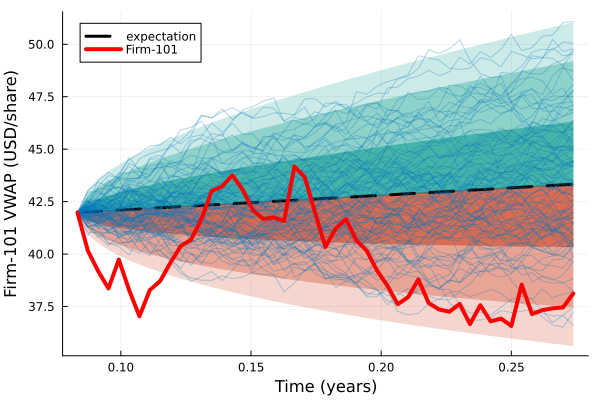

In [13]:
L68 = expectation[:,2] .- sqrt.(variance[:,2])
U68 = expectation[:,2] .+ sqrt.(variance[:,2])
L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])


plot(expectation[:,1], expectation[:,2], fillrange=L68, c=colors[5], alpha=0.5, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=colors[6], alpha=0.5, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=colors[5], alpha=0.3, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=colors[6], alpha=0.3, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=colors[5], alpha=0.2, label="")
plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=colors[6], alpha=0.2, label="")

plot!(expectation[:,1], expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
plot!(X[:,1],X[:,2:end], label="", c=colors[2], alpha=0.3)
plot!(X[:,1], firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
    label="Firm-$(firm_index)")

xlabel!("Time (years)", fontsize=18)
ylabel!("Firm-$(firm_index) VWAP (USD/share)", fontsize=18)

### Was this a successful simulation?
Determining if a model accurately represents data can be done in various ways, but we will utilize a straightforward functional test. This test involves checking if the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given range ($t_{j}\in\mathcal{I}_{k}$). 

* If the simulation meets this requirement, it is deemed a `success`. The values for $L_{j}$ and $U_{j}$ can be customized, but we set these to $\mu\pm{2.576}\cdot{\sigma}$, where $\mu$ represents the expected value and $\sigma$ is the standard deviation of the geometric Brownian motion simulation. 
* However, if the actual price exceeds the given bounds at any point, the simulation is considered a `failure`.

In [14]:
L = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
U = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])
   
# check the bounds: if below L, or above U then simulation failed
success_flag = true;
for k ∈ 1:T
    if (firm_data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (firm_data[start_index+k-1,:volume_weighted_average_price] > U[k])
        success_flag = false;
        break;
    end
end

println("The simultion of the VWAP of Firm-$(firm_index) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")

The simultion of the VWAP of Firm-101 between (21 -> 69) was successful: false
